In [2]:
import pandas as pd
import numpy as np
import mplfinance as mpf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.tsa.stattools as ts
import pandas_ta as ta
import ccxt
import seaborn as sns
#from pykalman import KalmanFilter


#Exchange is FTX:
ftx = ccxt.ftx()

In [1]:

def get_ohlc_ccxt(market, timeframe):
    data = ftx.fetch_ohlcv(market, timeframe, limit=5000)
    ohlcv = pd.DataFrame(data, columns=['time', 'open', 'high', 'low', 'close', 'volume'])
    ohlcv = ohlcv.drop_duplicates(subset=['time', 'open', 'high', 'low', 'close', 'volume'], keep='first')
    ohlcv['time'] = ohlcv['time'].astype('int64')
    ohlcv['time'] = ohlcv['time']/1000
    ohlcv = ohlcv.set_index(pd.to_datetime(ohlcv['time'], unit='s'))
    ohlcv.index.names = ['date']
    ohlcv = ohlcv.drop(['time'], axis = 1)
    return ohlcv


def check_pair(first_market, second_market, timeframe):
    first = get_ohlc_ccxt(first_market, timeframe)
    second = get_ohlc_ccxt(second_market, timeframe)

    if len(first) != len(second):
        length = min(len(first), len(second))
        first = first.iloc[-length:]
        second = second.iloc[-length:]

    x = first['close'].to_numpy()
    y = second['close'].to_numpy()
    
    first['logret'] = x.ta.log_return()
    second['logret'] = y.ta.log_return()

    xr = first['logret'].fillna(0)
    yr = second['logret'].fillna(0)

    coint = ts.coint(xr.to_numpy(), yr.to_numpy())
    p_value = coint[1]

    print('Cointegration:', first_market, second_market, p_value)
    spread = xr-yr
    
    return first, second


In [3]:
Market1 = get_ohlc_ccxt('BTC-PERP', '5m')
Market2 = get_ohlc_ccxt('ETH-PERP', '5m')


In [5]:
MergedMarkets = Market1.merge(Market2, on ='date', suffixes=['_BTCPERP', '_ETHPERP'])

close_BTCPERP = MergedMarkets.loc[:,'close_BTCPERP']
close_ETHPERP = MergedMarkets.loc[:,'close_ETHPERP']



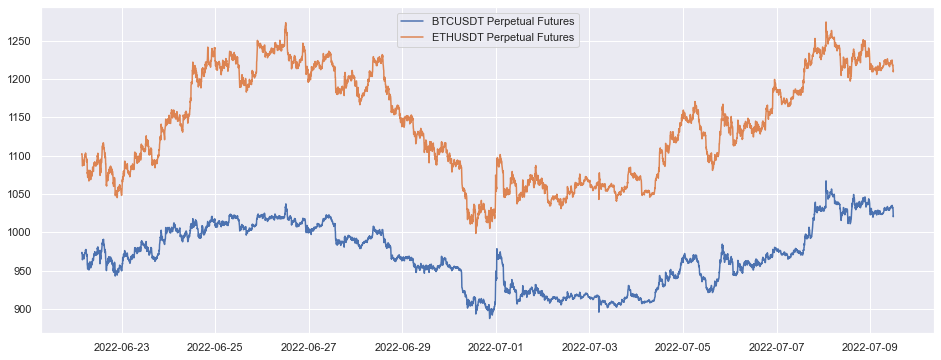

In [6]:
sns.set()
plt.figure(figsize=(16,6))
plt.plot(close_BTCPERP/21, label = 'BTCUSDT Perpetual Futures') 
plt.plot(close_ETHPERP, label = 'ETHUSDT Perpetual Futures')
plt.legend(loc = 'upper center')
plt.show()

In [7]:
logret_BTCPERP = pd.DataFrame(100 * np.diff(np.log(close_BTCPERP)))
logret_BTCPERP.columns = ['Log-returns']
logret_BTCPERP.index = close_BTCPERP.iloc[1:].index

logret_ETHPERP = pd.DataFrame(100 * np.diff(np.log(close_ETHPERP)))
logret_ETHPERP.columns = ['Log-returns']
logret_ETHPERP.index = close_ETHPERP.iloc[1:].index

In [8]:
RollingHourlyCorrelations = logret_BTCPERP.rolling(12).corr(logret_ETHPERP, ddof = 1, pairwise=False).dropna()

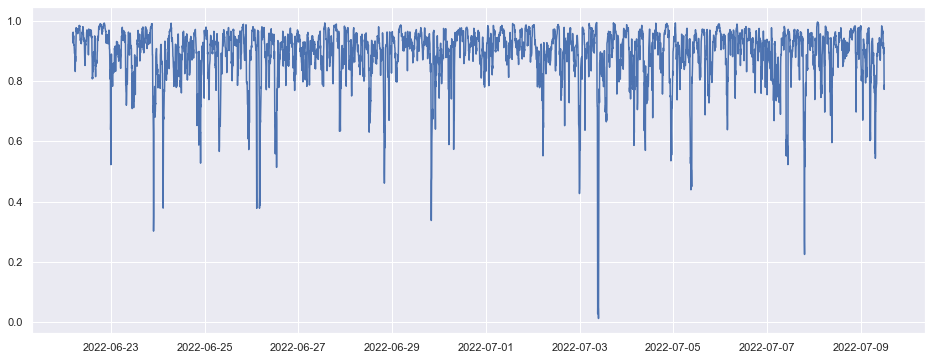

In [9]:
#Correlation does not imply causation. 
sns.set()
plt.figure(figsize=(16,6))
plt.plot(RollingHourlyCorrelations)

In [ ]:
data = check_pair('BTC-PERP', 'ETH-PERP', '5m')